<a href="https://colab.research.google.com/github/pryplotsky/C5.-Deep-Survival-Analysis-and-Time-Varying-Covariates/blob/main/CPH0012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cox Time model is taken from:
https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html

In [ ]:
#Some basic istructions:
# 1. Each line of code must be FULLY DOCUMENTED
# 2. Everything should be inside a class(classes) or functions if you don't know OOP
# 3. Please avoid using values (numbers/string/....) use instead variables
# 4. Use default values for your function arguments whenever possible

#Plan:
# We need functions/methods for:
# 1. Read, save and load a data - DONE
# 2. Pre-process the data (if needed) - DONE
# 3. Split the data into 3 sets: train(80%)  + dev (10%) + test(10%) - DONE
# 4. Obtain relevant statistics (if needed) - NOT NOW
# 5. Create Cox time ( CPH for TVC) model - In Progress
# a) Calculate C index for test set
# b) Kaplan-Meier curve (total survival distribution)
# c) Excample for 5 random observations (individual survival distribution)
# d) I don't thing CoxTimeVaryingFitter is a neutonal network. I think is a classic Cox proportional hasard, because ve dont have:
# loss function, any parametrs for validation...

In [1]:
### Install  packages and define global variables
#Basic:
import pandas as pd
import numpy as np
# 1. Read, save and load a data:
import os
import pickle
# 2. Pre-process the data 
from sklearn import preprocessing
# 3. Split the data into 3 sets
import sklearn
from sklearn.model_selection import train_test_split
# 5. Create Cox time ( CPH for TVC) model
!pip install lifelines
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

     |████████████████████████████████| 348 kB 8.5 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=f46d214672f330e721a78564eb26af1bdbe1827b36558b0e1ea91bfd4f9d0b48
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


**Main part of code**

In [2]:
### Create class Preparation with 5 methods: __init__, readdf, save, load, cleaning and splitdata
class Preparation:
  def __init__(self):# Dont use any additional attributes    
    self.df = None # Placeholders. Set varabels as none and then update a resut 
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test  = None
    self.X_train = None
    self.X_val = None
    self.y_train = None
    self.y_val = None
    self.cols_standardize = ['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time','REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'] 
    #self.cols_standardize = ['rate_time','hpi_time', 'gdp_time']
### Pre-processing:
  # Read data
  def readdf (self, sep=",", filename="dcr.csv", cwd = os.getcwd()): # Method whith 3 def attributes: sep - separator, getcwd - path to your working directory
    file_name = cwd + "/" + filename # Get path of file
    data = pd.read_csv(file_name, sep= sep) # Read csv
    self.df = data # Save filtered dataset 
    return self.df # Print dataset
  # Clean data
  def cleaning (self, data,longformat=True,individual="id", stop="time", stopname="start"): 
    col1 = data.loc[:,self.cols_standardize]# separate the variables to be standartized
    col2 = data.drop(columns=self.cols_standardize)# separate the variables not to be standartized
    standard = preprocessing.scale(col1)# standardization of variables
    df2 = pd.DataFrame(standard, columns=self.cols_standardize)# to dataframe
    df3=pd.concat([col2,df2], axis=1)# merge 2 df
    data2 = df3.drop_duplicates() #drop double row entries
    self.df = data2 # Save filtered dataset
    if longformat:# Bring data into long format (necessary for using the lifeline package's Cox’s time varying proportional hazard model) 
        data2[stopname] = data2.groupby(individual)[stop].shift(1)
        data2[stopname] = data2[stopname].fillna(0)
        self.df = data2 # Save filtered dataset
        return self.df # Print dataset
### Saving and load objects as binary mode
  def save (self, dataname, dataframe , cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl','wb') as path_name: # save df, 'wb' specifies 'write'
      pickle.dump(dataframe, path_name)  
  def load (self, dataname, cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl' ,'rb') as path_name:# load df, 'rb' specifies 'read'
      dataframe = pickle.load(path_name)
      return dataframe # Print dataset
### Split the data into 3 sets: train(80%)  + dev (10%) + test(10%)  
  def splitdata (self, Xvar, yvar, perc_test=0.1, perc_val=1/9,  shuffle=False):# Method needs 5 arguments: X set with independent vars, y - set w. dependent vars, perc_test=percentage for test set, perc_val=valuation set (=(1-perc_test)*perc_val) 
    self.X_train, self.X_test, self.y_train, self.y_test = sklearn.model_selection.train_test_split(Xvar, yvar, test_size=perc_test,  shuffle=shuffle)# Split data not randomly to train 90% and test 10%
    self.X_train, self.X_val, self.y_train, self.y_val = sklearn.model_selection.train_test_split(self.X_train, self.y_train, test_size=perc_val,  shuffle=shuffle) # Split train data not randomly to train 80% and valid 10%
    print(len(self.X_train), len(self.X_val), len(self.X_test)) # len - length 

**Testing**

In [3]:
temp=Preparation()
newdf = temp.readdf()
www2=temp.cleaning(newdf)
temp.save('qwer', newdf)
temp.splitdata(www2.loc[:,www2.columns != "status_time"], yvar=www2.status_time)
temp.X_train

49712 6214 6214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,time,orig_time,first_time,mat_time,res_time,investor_orig_time,state_orig_time,default_time,payoff_time,lgd_time,recovery_res,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,start
0,4,25,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.879684,-1.757930,1.826121,2.694535,1.527288,0.775016,-0.945711,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0.0
1,4,26,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.880396,-1.754506,1.826121,2.694535,1.484264,0.392294,-0.945711,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,25.0
2,4,27,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.881126,-1.742832,1.826121,2.694535,1.386286,0.499958,-1.102219,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,26.0
3,4,28,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.881862,-1.730835,2.004628,2.694535,1.287946,-0.079699,-0.997880,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,27.0
4,4,29,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.882588,-1.720905,2.004628,2.694535,1.204791,0.157680,-1.050050,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49745,38915,33,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.479806,-0.180001,-0.553976,-0.538972,-0.127495,-0.280491,-0.789202,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,32.0
49746,38915,34,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.467482,-0.086469,-0.553976,-0.538972,-0.386721,-0.869748,-0.371846,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,33.0
49747,38915,35,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.460027,0.099460,-0.553976,-0.538972,-0.793819,-2.144884,-0.006660,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,34.0
49748,38915,36,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.447430,0.288754,-0.553976,-0.538972,-1.177416,-2.508644,0.671543,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,35.0


**Cox Time**

In [23]:
result_c_index=[]
result_brier_score=[]
pred_time=[1, 3, 5, 10]

In [24]:
#var_list=['id','time','start','rate_time', 'gdp_time','hpi_time','default_time']
k_event=['default_time', 'payoff_time']
var_list=['id','time','start','balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time','REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time','payoff_time']

In [25]:
from sklearn.metrics import brier_score_loss

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column status_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['default_time'].astype(bool)
>>> print(df.loc[events, 'status_time'].var())
>>> print(df.loc[~events, 'status_time'].var())

A very low variance means that the column status_time completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -8317.06615, newton_decrement = 0.00000, seconds_since_start = 0.6Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49712 periods, 3920 subjects, 1209 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49712
  number of events = 1209
partial log-likelihood = -8317.07
  time fit was run = 2021-08-27 20:27:18 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
balance_time             -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
LTV_time                  0.05       1.05       0.01             0.02             0.07                 1.02                 1.07
interest_rate_time        0.06       1.07       0.01             0.04             0.09                 1.04                 1.09
rate_time                 0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
hpi_time                 -0.02       0.98       0.01            -0.04             0.01                 0.96                 1.01
gdp_time                  0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
uer_time                  0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
balance_orig_time        -0.01       0.99       0.01            -0.04             0.01                 0.96                 1.01
FICO_orig_time           -0.08       0.93       0.01            -0.10            -0.05                 0.90                 0.95
LTV_orig_time             0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
Interest_Rate_orig_time   0.01       1.01       0.01            -0.02             0.03                 0.98                 1.04
hpi_orig_time             0.02       1.02       0.01            -0.01             0.04                 0.99                 1.05
REtype_CO_orig_time      -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
REtype_PU_orig_time       0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
REtype_SF_orig_time       0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
status_time               0.88       2.40       0.03             0.83             0.93                 2.29                 2.53

                            z      p   -log2(p)
covariate                                      
balance_time            -0.44   0.66       0.60
LTV_time                 3.80 <0.005      12.76
interest_rate_time       4.86 <0.005      19.70
rate_time                2.99 <0.005       8.47
hpi_time                -1.14   0.25       1.97
gdp_time                 0.10   0.92       0.12
uer_time                 0.22   0.83       0.28
balance_orig_time       -1.04   0.30       1.74
FICO_orig_time          -5.72 <0.005      26.51
LTV_orig_time            2.98 <0.005       8.45
Interest_Rate_orig_time  0.70   0.48       1.05
hpi_orig_time            1.42   0.15       2.69
REtype_CO_orig_time     -0.54   0.59       0.77
REtype_PU_orig_time      0.07   0.95       0.08
REtype_SF_orig_time      0.90   0.37       1.45
status_time             34.20 <0.005     849.37
---
Partial AIC = 16666.13
log-likelihood ratio test = 1142.07 on 16 df
-log2(p) of ll-ratio test = 772.01

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column status_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['default_time'].astype(bool)
>>> print(df.loc[events, 'status_time'].var())
>>> print(df.loc[~events, 'status_time'].var())

A very low variance means that the column status_time completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -8317.06615, newton_decrement = 0.00000, seconds_since_start = 0.6Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49712 periods, 3920 subjects, 1209 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49712
  number of events = 1209
partial log-likelihood = -8317.07
  time fit was run = 2021-08-27 20:27:19 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
balance_time             -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
LTV_time                  0.05       1.05       0.01             0.02             0.07                 1.02                 1.07
interest_rate_time        0.06       1.07       0.01             0.04             0.09                 1.04                 1.09
rate_time                 0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
hpi_time                 -0.02       0.98       0.01            -0.04             0.01                 0.96                 1.01
gdp_time                  0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
uer_time                  0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
balance_orig_time        -0.01       0.99       0.01            -0.04             0.01                 0.96                 1.01
FICO_orig_time           -0.08       0.93       0.01            -0.10            -0.05                 0.90                 0.95
LTV_orig_time             0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
Interest_Rate_orig_time   0.01       1.01       0.01            -0.02             0.03                 0.98                 1.04
hpi_orig_time             0.02       1.02       0.01            -0.01             0.04                 0.99                 1.05
REtype_CO_orig_time      -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
REtype_PU_orig_time       0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
REtype_SF_orig_time       0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
status_time               0.88       2.40       0.03             0.83             0.93                 2.29                 2.53

                            z      p   -log2(p)
covariate                                      
balance_time            -0.44   0.66       0.60
LTV_time                 3.80 <0.005      12.76
interest_rate_time       4.86 <0.005      19.70
rate_time                2.99 <0.005       8.47
hpi_time                -1.14   0.25       1.97
gdp_time                 0.10   0.92       0.12
uer_time                 0.22   0.83       0.28
balance_orig_time       -1.04   0.30       1.74
FICO_orig_time          -5.72 <0.005      26.51
LTV_orig_time            2.98 <0.005       8.45
Interest_Rate_orig_time  0.70   0.48       1.05
hpi_orig_time            1.42   0.15       2.69
REtype_CO_orig_time     -0.54   0.59       0.77
REtype_PU_orig_time      0.07   0.95       0.08
REtype_SF_orig_time      0.90   0.37       1.45
status_time             34.20 <0.005     849.37
---
Partial AIC = 16666.13
log-likelihood ratio test = 1142.07 on 16 df
-log2(p) of ll-ratio test = 772.01

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column status_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['default_time'].astype(bool)
>>> print(df.loc[events, 'status_time'].var())
>>> print(df.loc[~events, 'status_time'].var())

A very low variance means that the column status_time completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -8317.06615, newton_decrement = 0.00000, seconds_since_start = 0.6Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49712 periods, 3920 subjects, 1209 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49712
  number of events = 1209
partial log-likelihood = -8317.07
  time fit was run = 2021-08-27 20:27:20 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
balance_time             -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
LTV_time                  0.05       1.05       0.01             0.02             0.07                 1.02                 1.07
interest_rate_time        0.06       1.07       0.01             0.04             0.09                 1.04                 1.09
rate_time                 0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
hpi_time                 -0.02       0.98       0.01            -0.04             0.01                 0.96                 1.01
gdp_time                  0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
uer_time                  0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
balance_orig_time        -0.01       0.99       0.01            -0.04             0.01                 0.96                 1.01
FICO_orig_time           -0.08       0.93       0.01            -0.10            -0.05                 0.90                 0.95
LTV_orig_time             0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
Interest_Rate_orig_time   0.01       1.01       0.01            -0.02             0.03                 0.98                 1.04
hpi_orig_time             0.02       1.02       0.01            -0.01             0.04                 0.99                 1.05
REtype_CO_orig_time      -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
REtype_PU_orig_time       0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
REtype_SF_orig_time       0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
status_time               0.88       2.40       0.03             0.83             0.93                 2.29                 2.53

                            z      p   -log2(p)
covariate                                      
balance_time            -0.44   0.66       0.60
LTV_time                 3.80 <0.005      12.76
interest_rate_time       4.86 <0.005      19.70
rate_time                2.99 <0.005       8.47
hpi_time                -1.14   0.25       1.97
gdp_time                 0.10   0.92       0.12
uer_time                 0.22   0.83       0.28
balance_orig_time       -1.04   0.30       1.74
FICO_orig_time          -5.72 <0.005      26.51
LTV_orig_time            2.98 <0.005       8.45
Interest_Rate_orig_time  0.70   0.48       1.05
hpi_orig_time            1.42   0.15       2.69
REtype_CO_orig_time     -0.54   0.59       0.77
REtype_PU_orig_time      0.07   0.95       0.08
REtype_SF_orig_time      0.90   0.37       1.45
status_time             34.20 <0.005     849.37
---
Partial AIC = 16666.13
log-likelihood ratio test = 1142.07 on 16 df
-log2(p) of ll-ratio test = 772.01

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column status_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['default_time'].astype(bool)
>>> print(df.loc[events, 'status_time'].var())
>>> print(df.loc[~events, 'status_time'].var())

A very low variance means that the column status_time completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -8317.06615, newton_decrement = 0.00000, seconds_since_start = 0.6Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49712 periods, 3920 subjects, 1209 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49712
  number of events = 1209
partial log-likelihood = -8317.07
  time fit was run = 2021-08-27 20:27:21 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
balance_time             -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
LTV_time                  0.05       1.05       0.01             0.02             0.07                 1.02                 1.07
interest_rate_time        0.06       1.07       0.01             0.04             0.09                 1.04                 1.09
rate_time                 0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
hpi_time                 -0.02       0.98       0.01            -0.04             0.01                 0.96                 1.01
gdp_time                  0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
uer_time                  0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
balance_orig_time        -0.01       0.99       0.01            -0.04             0.01                 0.96                 1.01
FICO_orig_time           -0.08       0.93       0.01            -0.10            -0.05                 0.90                 0.95
LTV_orig_time             0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
Interest_Rate_orig_time   0.01       1.01       0.01            -0.02             0.03                 0.98                 1.04
hpi_orig_time             0.02       1.02       0.01            -0.01             0.04                 0.99                 1.05
REtype_CO_orig_time      -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
REtype_PU_orig_time       0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
REtype_SF_orig_time       0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
status_time               0.88       2.40       0.03             0.83             0.93                 2.29                 2.53

                            z      p   -log2(p)
covariate                                      
balance_time            -0.44   0.66       0.60
LTV_time                 3.80 <0.005      12.76
interest_rate_time       4.86 <0.005      19.70
rate_time                2.99 <0.005       8.47
hpi_time                -1.14   0.25       1.97
gdp_time                 0.10   0.92       0.12
uer_time                 0.22   0.83       0.28
balance_orig_time       -1.04   0.30       1.74
FICO_orig_time          -5.72 <0.005      26.51
LTV_orig_time            2.98 <0.005       8.45
Interest_Rate_orig_time  0.70   0.48       1.05
hpi_orig_time            1.42   0.15       2.69
REtype_CO_orig_time     -0.54   0.59       0.77
REtype_PU_orig_time      0.07   0.95       0.08
REtype_SF_orig_time      0.90   0.37       1.45
status_time             34.20 <0.005     849.37
---
Partial AIC = 16666.13
log-likelihood ratio test = 1142.07 on 16 df
-log2(p) of ll-ratio test = 772.01

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column status_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['payoff_time'].astype(bool)
>>> print(df.loc[events, 'status_time'].var())
>>> print(df.loc[~events, 'status_time'].var())

A very low variance means that the column status_time completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 6: norm_delta = 0.00000, step_size = 1.00000, ll = -11987.29350, newton_decrement = 0.00000, seconds_since_start = 0.8Convergence completed after 6 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49712 periods, 3920 subjects, 2129 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49712
  number of events = 2129
partial log-likelihood = -11987.29
  time fit was run = 2021-08-27 20:27:22 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
balance_time             -0.03       0.97       0.01            -0.06            -0.01                 0.94                 0.99
LTV_time                 -0.06       0.94       0.01            -0.08            -0.03                 0.92                 0.97
interest_rate_time        0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
rate_time                -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
hpi_time                 -0.06       0.94       0.01            -0.09            -0.03                 0.92                 0.97
gdp_time                  0.04       1.04       0.01             0.01             0.07                 1.01                 1.07
uer_time                  0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
balance_orig_time        -0.03       0.97       0.01            -0.05            -0.00                 0.95                 1.00
FICO_orig_time           -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
LTV_orig_time            -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
Interest_Rate_orig_time  -0.05       0.95       0.01            -0.08            -0.03                 0.92                 0.97
hpi_orig_time            -0.14       0.87       0.01            -0.16            -0.11                 0.85                 0.89
REtype_CO_orig_time       0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
REtype_PU_orig_time      -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
REtype_SF_orig_time      -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
status_time               1.90       6.69       0.02             1.86             1.94                 6.43                 6.95

                             z      p   -log2(p)
covariate                                       
balance_time             -2.81   0.01       7.64
LTV_time                 -4.54 <0.005      17.43
interest_rate_time        1.05   0.29       1.77
rate_time                -2.74   0.01       7.36
hpi_time                 -4.37 <0.005      16.27
gdp_time                  2.93 <0.005       8.19
uer_time                  1.42   0.16       2.68
balance_orig_time        -2.12   0.03       4.89
FICO_orig_time           -1.59   0.11       3.17
LTV_orig_time            -0.26   0.79       0.34
Interest_Rate_orig_time  -4.54 <0.005      17.47
hpi_orig_time           -11.35 <0.005      96.83
REtype_CO_orig_time       0.28   0.78       0.36
REtype_PU_orig_time      -1.69   0.09       3.44
REtype_SF_orig_time      -0.06   0.95       0.07
status_time              97.05 <0.005        inf
---
Partial AIC = 24006.59
log-likelihood ratio test = 9034.41 on 16 df
-log2(p) of ll-ratio test = inf

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column status_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['payoff_time'].astype(bool)
>>> print(df.loc[events, 'status_time'].var())
>>> print(df.loc[~events, 'status_time'].var())

A very low variance means that the column status_time completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 6: norm_delta = 0.00000, step_size = 1.00000, ll = -11987.29350, newton_decrement = 0.00000, seconds_since_start = 0.8Convergence completed after 6 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49712 periods, 3920 subjects, 2129 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49712
  number of events = 2129
partial log-likelihood = -11987.29
  time fit was run = 2021-08-27 20:27:23 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
balance_time             -0.03       0.97       0.01            -0.06            -0.01                 0.94                 0.99
LTV_time                 -0.06       0.94       0.01            -0.08            -0.03                 0.92                 0.97
interest_rate_time        0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
rate_time                -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
hpi_time                 -0.06       0.94       0.01            -0.09            -0.03                 0.92                 0.97
gdp_time                  0.04       1.04       0.01             0.01             0.07                 1.01                 1.07
uer_time                  0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
balance_orig_time        -0.03       0.97       0.01            -0.05            -0.00                 0.95                 1.00
FICO_orig_time           -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
LTV_orig_time            -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
Interest_Rate_orig_time  -0.05       0.95       0.01            -0.08            -0.03                 0.92                 0.97
hpi_orig_time            -0.14       0.87       0.01            -0.16            -0.11                 0.85                 0.89
REtype_CO_orig_time       0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
REtype_PU_orig_time      -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
REtype_SF_orig_time      -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
status_time               1.90       6.69       0.02             1.86             1.94                 6.43                 6.95

                             z      p   -log2(p)
covariate                                       
balance_time             -2.81   0.01       7.64
LTV_time                 -4.54 <0.005      17.43
interest_rate_time        1.05   0.29       1.77
rate_time                -2.74   0.01       7.36
hpi_time                 -4.37 <0.005      16.27
gdp_time                  2.93 <0.005       8.19
uer_time                  1.42   0.16       2.68
balance_orig_time        -2.12   0.03       4.89
FICO_orig_time           -1.59   0.11       3.17
LTV_orig_time            -0.26   0.79       0.34
Interest_Rate_orig_time  -4.54 <0.005      17.47
hpi_orig_time           -11.35 <0.005      96.83
REtype_CO_orig_time       0.28   0.78       0.36
REtype_PU_orig_time      -1.69   0.09       3.44
REtype_SF_orig_time      -0.06   0.95       0.07
status_time              97.05 <0.005        inf
---
Partial AIC = 24006.59
log-likelihood ratio test = 9034.41 on 16 df
-log2(p) of ll-ratio test = inf

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column status_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['payoff_time'].astype(bool)
>>> print(df.loc[events, 'status_time'].var())
>>> print(df.loc[~events, 'status_time'].var())

A very low variance means that the column status_time completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 6: norm_delta = 0.00000, step_size = 1.00000, ll = -11987.29350, newton_decrement = 0.00000, seconds_since_start = 0.8Convergence completed after 6 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49712 periods, 3920 subjects, 2129 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49712
  number of events = 2129
partial log-likelihood = -11987.29
  time fit was run = 2021-08-27 20:27:24 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
balance_time             -0.03       0.97       0.01            -0.06            -0.01                 0.94                 0.99
LTV_time                 -0.06       0.94       0.01            -0.08            -0.03                 0.92                 0.97
interest_rate_time        0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
rate_time                -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
hpi_time                 -0.06       0.94       0.01            -0.09            -0.03                 0.92                 0.97
gdp_time                  0.04       1.04       0.01             0.01             0.07                 1.01                 1.07
uer_time                  0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
balance_orig_time        -0.03       0.97       0.01            -0.05            -0.00                 0.95                 1.00
FICO_orig_time           -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
LTV_orig_time            -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
Interest_Rate_orig_time  -0.05       0.95       0.01            -0.08            -0.03                 0.92                 0.97
hpi_orig_time            -0.14       0.87       0.01            -0.16            -0.11                 0.85                 0.89
REtype_CO_orig_time       0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
REtype_PU_orig_time      -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
REtype_SF_orig_time      -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
status_time               1.90       6.69       0.02             1.86             1.94                 6.43                 6.95

                             z      p   -log2(p)
covariate                                       
balance_time             -2.81   0.01       7.64
LTV_time                 -4.54 <0.005      17.43
interest_rate_time        1.05   0.29       1.77
rate_time                -2.74   0.01       7.36
hpi_time                 -4.37 <0.005      16.27
gdp_time                  2.93 <0.005       8.19
uer_time                  1.42   0.16       2.68
balance_orig_time        -2.12   0.03       4.89
FICO_orig_time           -1.59   0.11       3.17
LTV_orig_time            -0.26   0.79       0.34
Interest_Rate_orig_time  -4.54 <0.005      17.47
hpi_orig_time           -11.35 <0.005      96.83
REtype_CO_orig_time       0.28   0.78       0.36
REtype_PU_orig_time      -1.69   0.09       3.44
REtype_SF_orig_time      -0.06   0.95       0.07
status_time              97.05 <0.005        inf
---
Partial AIC = 24006.59
log-likelihood ratio test = 9034.41 on 16 df
-log2(p) of ll-ratio test = inf

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column status_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['payoff_time'].astype(bool)
>>> print(df.loc[events, 'status_time'].var())
>>> print(df.loc[~events, 'status_time'].var())

A very low variance means that the column status_time completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 6: norm_delta = 0.00000, step_size = 1.00000, ll = -11987.29350, newton_decrement = 0.00000, seconds_since_start = 0.8Convergence completed after 6 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49712 periods, 3920 subjects, 2129 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49712
  number of events = 2129
partial log-likelihood = -11987.29
  time fit was run = 2021-08-27 20:27:25 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
balance_time             -0.03       0.97       0.01            -0.06            -0.01                 0.94                 0.99
LTV_time                 -0.06       0.94       0.01            -0.08            -0.03                 0.92                 0.97
interest_rate_time        0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
rate_time                -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
hpi_time                 -0.06       0.94       0.01            -0.09            -0.03                 0.92                 0.97
gdp_time                  0.04       1.04       0.01             0.01             0.07                 1.01                 1.07
uer_time                  0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
balance_orig_time        -0.03       0.97       0.01            -0.05            -0.00                 0.95                 1.00
FICO_orig_time           -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
LTV_orig_time            -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
Interest_Rate_orig_time  -0.05       0.95       0.01            -0.08            -0.03                 0.92                 0.97
hpi_orig_time            -0.14       0.87       0.01            -0.16            -0.11                 0.85                 0.89
REtype_CO_orig_time       0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
REtype_PU_orig_time      -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
REtype_SF_orig_time      -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
status_time               1.90       6.69       0.02             1.86             1.94                 6.43                 6.95

                             z      p   -log2(p)
covariate                                       
balance_time             -2.81   0.01       7.64
LTV_time                 -4.54 <0.005      17.43
interest_rate_time        1.05   0.29       1.77
rate_time                -2.74   0.01       7.36
hpi_time                 -4.37 <0.005      16.27
gdp_time                  2.93 <0.005       8.19
uer_time                  1.42   0.16       2.68
balance_orig_time        -2.12   0.03       4.89
FICO_orig_time           -1.59   0.11       3.17
LTV_orig_time            -0.26   0.79       0.34
Interest_Rate_orig_time  -4.54 <0.005      17.47
hpi_orig_time           -11.35 <0.005      96.83
REtype_CO_orig_time       0.28   0.78       0.36
REtype_PU_orig_time      -1.69   0.09       3.44
REtype_SF_orig_time      -0.06   0.95       0.07
status_time              97.05 <0.005        inf
---
Partial AIC = 24006.59
log-likelihood ratio test = 9034.41 on 16 df
-log2(p) of ll-ratio test = inf

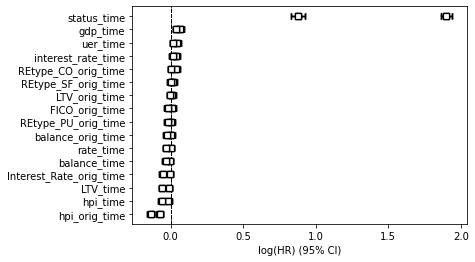

In [26]:
for j in k_event:
  var_list=['id','time','start','balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time','REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time']
  var_list.append(j)
  X_train=temp.X_train
  y_train=temp.y_train
  df_full=X_train[var_list]
  df2=pd.concat([df_full,  y_train], axis=1)

  #df2b=df2.loc[df2['time']>=(df2['time'].max()-pred_time)]

  df3=df2.dropna()
  for i in pred_time:
    X_test=temp.X_test
    y_test=temp.y_test

    df_full_test=X_test[var_list]
    df2_test=pd.concat([df_full_test,  y_test], axis=1)

    df2_testb=df2_test.loc[df2_test['time']<=(df2_test['time'].max()-i)]
    #df2_testc=df2_testb.loc[df2_testb['start']<=(pred_time)]

    df3_test=df2_testb.dropna()
    df3_test
    ctv = CoxTimeVaryingFitter(penalizer=0.1)
    ctv.fit(df3, id_col="id", event_col=j, start_col="start", stop_col="time", show_progress=True )
    ctv.print_summary() #summary of the fitted model with different values of the parametric partial hazard and Partial AIC
    ctv.plot() #visiualizaton of the covariates and how they are distributed
    ctv.predict_partial_hazard(df3_test) #predicting the partial hazard
    #survival = KaplanMeierFitter() #
    #survival.fit(df3['time'], df3[j]) #Survival Curve for our dataset
    #survival.plot() #plot the Curve
    #plt.ylabel("Probability of survival")
    #plt.show()
    #plt.close()
    pred=ctv.predict_partial_hazard(df3_test)/ctv.predict_partial_hazard(df3_test).max(),
    res1=concordance_index(df3_test['time'], -pred[0], df3_test[j])
    #res1=concordance_index(df3_test['time'], -ctv.predict_partial_hazard(df3_test), df3_test[j])
    res2=brier_score_loss(df3_test[j],pred[0])
    result_c_index.append(res1)
    result_brier_score.append(res2)

In [27]:
result_c_index

[0.9710045806874352,
 0.9701402843245882,
 0.9689004503039799,
 0.9650155493183155,
 0.9911502882657541,
 0.9911624156263067,
 0.9917563938521916,
 0.9927245270236894]

In [28]:
result_brier_score

[0.043889292758093626,
 0.04506790658179855,
 0.04663960717165344,
 0.050821546564519676,
 0.004962710251859077,
 0.005096502097117878,
 0.00538294423461908,
 0.006003270380586328]

In [32]:
df_to_print=pd.DataFrame({'Event': k_event*4, 'Time': np.repeat(pred_time, 2 ), 'C-index': result_c_index,'Brier score': result_brier_score })
df_to_print.to_excel('df_res.xlsx')
df_to_print

,Event,Time,C-index,Brier score
0,default_time,1,0.971005,0.043889
1,payoff_time,1,0.970140,0.045068
2,default_time,3,0.968900,0.046640
3,payoff_time,3,0.965016,0.050822
4,default_time,5,0.991150,0.004963
5,payoff_time,5,0.991162,0.005097
6,default_time,10,0.991756,0.005383
7,payoff_time,10,0.992725,0.006003


In [ ]:
import seaborn as sns

corr= df3.corr()

f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], #plot a correlation heatmap with only values exceeding absolute 0.30
            annot=True);